In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from torch import Tensor
import torch
import torch.nn as nn
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

## 변수 설명

- **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
- **annual_inc** : 연 소득 (annual income)
- **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
- **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
- **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
- **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
- **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
- **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
- **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
- **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
- **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
- **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
- **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
- **delinq_amnt** : 체납 금액 (delinquency amount)
- **tax_liens** : 세금 저당권의 수 (Number of tax liens)
- **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
- **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
- **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
- **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
- **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
- **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
- **funded_amnt** : 대출액 (Funded amount)
- **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
- **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
- **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
- **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
- **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
- **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
- **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
- **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
- **total_rec_int** : 이자 상환액 (Interest received to date)
- **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
- **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
- **depvar** : 고객의 부도 여부 (dependent variable)

## 파일 읽어오고 간단한 전처리

In [84]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')

# out_prncp와 완전 동일함, funded_amnt_inv는 funded_amnt와 유의미한 차이를 못발견함
df=df.drop(['out_prncp_inv', 'funded_amnt_inv'], axis=1)
df_test=df_test.drop(['out_prncp_inv', 'funded_amnt_inv'], axis=1)

In [85]:
df.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.130833,7.436061e+04,18.514508,0.343700,0.668880,0.235720,16090.202820,24.675910,0.018810,0.005800,250.588120,1.305281e+05,0.009630,19.288330,0.063820,0.065400,0.326240,0.089410,0.08058,0.059480,0.060710,0.046640,0.045320,0.045690,0.038570,0.075550,0.066410,0.000330,0.466120,0.000070,0.000050,0.110880,0.422550,0.321800,0.390200,0.288000,0.009620,0.226720,0.582810,0.0,0.060400,0.004250,0.019830,0.01101,0.007310,0.058200,0.000650,0.011250,0.007070,0.000880,0.434430,0.565570,0.489320,0.052360,0.060090,0.045700,0.050750,0.048560,0.051340,0.053430,0.048960,0.050030,0.049460,13735.317750,2.448885e+00,0.855920,11.620700,434.077648,0.537233,0.253327,2491.282802,692.630550,696.630660,0.325690
std,0.044773,7.467409e+04,8.413049,0.905007,0.952044,0.661468,21569.939271,11.883834,0.150321,0.083585,2042.770881,1.503326e+05,0.110079,893.304366,0.468027,0.247232,0.468839,0.285336,0.27219,0.236522,0.238799,0.210868,0.208006,0.208813,0.192569,0.264278,0.248999,0.018163,0.498853,0.008366,0.007071,0.313985,0.493968,0.467169,0.487797,0.452833,0.097609,0.418712,0.493097,0.0,0.238228,0.065054,0.139417,0.10435,0.085186,0.234122,0.025487,0.105468,0.083786,0.029652,0.495684,0.495684,0.499888,0.222753,0.237655,0.208835,0.219488,0.214947,0.220691,0.224891,0.215786,0.218008,0.216828,8464.825314,1.489496e+01,0.351173,5.458774,265.921746,0.239373,18.053290,2706.262200,29.668017,29.668584,0.468634
min,0.053200,5.360000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [86]:
df_test.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,ID
count,35816.000000,3.581600e+04,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,3.581600e+04,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.0,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000,35816.000000
mean,0.130905,7.423457e+04,18.562074,0.347610,0.681567,0.233443,15954.732103,24.718980,0.019516,0.005947,242.271080,1.317939e+05,0.008488,20.318852,0.058493,0.064245,0.323152,0.091747,0.079545,0.059415,0.060197,0.047102,0.045818,0.047716,0.039815,0.075441,0.065809,0.000251,0.468841,0.000056,0.000056,0.110481,0.420315,0.320332,0.391445,0.288223,0.010358,0.220488,0.585102,0.0,0.061118,0.004272,0.020885,0.011755,0.008572,0.058745,0.000614,0.010331,0.006868,0.000893,0.434750,0.565250,0.491261,0.054417,0.058354,0.047772,0.050955,0.048330,0.051960,0.049363,0.048051,0.047577,0.051960,13700.353892,2.527038,0.855316,11.647504,432.935858,0.534209,0.357741,2479.502248,692.688044,696.688184,17907.500000
std,0.044379,8.566602e+04,8.361062,0.919794,0.969466,0.598784,21789.053346,11.858859,0.157049,0.083169,1846.310234,1.548473e+05,0.097922,1081.737877,0.366260,0.245192,0.467687,0.288672,0.270592,0.236403,0.237854,0.211860,0.209092,0.213168,0.195526,0.264106,0.247951,0.015850,0.499035,0.007473,0.007473,0.313493,0.493616,0.466611,0.488080,0.452942,0.101250,0.414582,0.492711,0.0,0.239550,0.065220,0.143000,0.107781,0.092187,0.235150,0.024777,0.101115,0.082592,0.029878,0.495731,0.495731,0.499931,0.226842,0.234415,0.213286,0.219909,0.214466,0.221949,0.216629,0.213877,0.212871,0.221949,8441.197725,14.311261,0.351787,5.436087,265.394230,0.237467,25.032649,2669.490453,29.489838,29.490561,10339.332957
min,0.053200,7.100000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

## total coll amount 에 관한 고찰

In [82]:
# tot_coll_amt 10이상 = 15841개 // 면서 1인것  5580개 .. 아 이것도 1:2 비율이네 이것자체만으로는 의미가 없음
df[(df['tot_coll_amt']>10) & df['depvar']==1]

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,my_multiple,my_multiple2,my_multiple3,my_multiple4
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,0.00,1,8,335.45,0.416,0.0,871.04,660,664,1,3.208032,16.801192,16.807235,1269.000
18,0.0890,96000.0,12.21,0,0,0,6231,19,0,0,241,37295,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,8000,0.00,1,11,254.03,0.385,0.0,448.07,680,684,1,1.086690,17.994196,18.000061,712.000
28,0.1075,50000.0,20.70,2,0,0,9880,18,0,0,600,29836,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,16000,0.00,1,4,521.93,0.546,0.0,1308.10,660,664,1,2.225250,17.312018,17.318060,1720.000
31,0.1398,54000.0,20.60,0,4,0,12593,52,0,0,1867,63376,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,13500,0.00,1,22,461.27,0.267,0.0,1533.93,665,669,1,2.879880,17.396526,17.402523,1887.300
89,0.1075,83000.0,7.48,0,0,1,8486,19,0,0,668,304678,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10000,16.31,1,9,326.21,0.648,0.0,1643.77,670,674,1,0.804100,17.833874,17.839826,1075.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99904,0.1349,75000.0,32.71,0,0,0,8624,30,0,0,1540,50262,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,17000,0.00,1,16,576.82,0.504,0.0,2498.54,675,679,1,4.412579,17.739956,17.745865,2293.300
99939,0.1561,75000.0,16.90,0,1,0,5390,19,0,0,157,29291,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,12150,0.00,1,8,424.83,0.642,0.0,1293.59,660,664,1,2.638090,17.717483,17.723526,1896.615
99964,0.1465,20400.0,27.25,1,1,0,4527,17,0,0,1040,9368,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,5500,0.00,1,10,189.72,0.285,0.0,1090.50,660,664,1,3.992125,16.415530,16.421572,805.750
99977,0.1199,72000.0,8.43,1,0,0,2765,28,0,0,2640,372260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,13050,0.00,1,10,433.39,0.247,0.0,2240.20,695,699,1,1.010757,17.728333,17.734072,1564.695


In [83]:
df[(df['tot_coll_amt']>10) & (df['depvar']==1)].describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,my_multiple,my_multiple2,my_multiple3,my_multiple4
count,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5.580000e+03,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.0,5580.0,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.0,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.0,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.0,5580.000000,5580.000000,5580.000000,5580.000000
mean,0.146903,66167.105867,19.221504,0.442115,0.846774,0.403405,10666.719534,24.999642,0.095161,0.006272,1556.936022,9.910202e+04,0.010394,48.837455,0.121685,0.064695,0.296237,0.089427,0.087993,0.059140,0.065950,0.046237,0.042652,0.048746,0.035663,0.073477,0.089785,0.000358,0.413262,0.0,0.0,0.120968,0.465412,0.259319,0.447670,0.293011,0.013082,0.167921,0.622760,0.0,0.062186,0.004839,0.018996,0.012007,0.006631,0.063082,0.001254,0.016667,0.010573,0.0,0.439247,0.560753,0.341935,0.049642,0.066308,0.064516,0.066846,0.062186,0.067921,0.066846,0.070430,0.074373,0.068996,12718.664875,4.834287,0.837814,11.964875,408.785520,0.486708,0.843299,2223.241369,675.816308,679.816308,1.0,2.873891,17.476123,17.482027,1919.548456
std,0.042458,41291.801897,8.523634,1.100954,1.059613,0.850011,14094.722136,11.663272,0.330791,0.112636,5260.810653,1.136358e+05,0.109911,1554.879108,0.593684,0.246010,0.456638,0.285384,0.283310,0.235907,0.248217,0.210016,0.202090,0.215355,0.185465,0.260941,0.285899,0.018930,0.492463,0.0,0.0,0.326119,0.498847,0.438300,0.497299,0.455184,0.113638,0.373830,0.484739,0.0,0.241515,0.069399,0.136524,0.108927,0.081167,0.243133,0.035400,0.128031,0.102292,0.0,0.496340,0.496340,0.474401,0.217223,0.248842,0.245692,0.249777,0.241515,0.251633,0.249777,0.255893,0.262400,0.253471,7785.631405,17.414319,0.368655,5.184655,248.827091,0.216859,31.652236,2307.068830,16.593290,16.593290,0.0,1.661239,0.518417,0.518402,1453.752393
min,0.053200,7000.000000,0.380000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,21.000000,2.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

## funded_amnt 와 funded_amnt_inv 차이 비교

솔직히 컴퓨터가 뭔가 더 차이를 찾아낼 순 있겠지만, 둘의 값의 차이는 99%data가 3%미만이고, 딱 봤을 때 유의미한 차이가 안보임. 그래서 학습시킬 땐 제외시킬 것임 

In [ ]:
df[df['funded_amnt']!=df['funded_amnt_inv']]  # 총10만개중 7100개

In [11]:
# 7%가 다름 근데 다른것보 크게 차이가 안남
my_ratio = df[df['funded_amnt']!=df['funded_amnt_inv']].shape[0]/df.shape[0]
my_ratio

0.07144

In [42]:
my_df = df.copy()
my_test_df = df_test.copy()

In [43]:
my_df['new'] = (df['funded_amnt']-df['funded_amnt_inv']) / (df['funded_amnt'])

In [33]:
# depvar 의 개수 = 32569개
my_df[my_df['depvar'] == 1].shape[0]

32569

In [41]:
# funded_amnt랑 funded_amnt_inv랑 차이나는게 1% 초과가 1298개 뿐 /3%초과면서 depvar=1 46개 , =0인 113개
my_df[((my_df['new'].abs())>0.03)&(my_df['depvar']==1)]


,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,new
12,0.2075,29624.0,22.33,0,1,0,3477,22,0,0,0,85968,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1500,1450.0,0.0,1,18,56.33,0.966,0.0,231.14,660,664,1,0.033333
207,0.1367,23465.0,16.33,0,2,0,1684,9,0,0,74,13319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,7400,7150.0,15.0,1,4,251.74,0.267,0.0,1539.73,665,669,1,0.033784
873,0.1757,61000.0,26.44,1,3,0,23202,34,0,0,200,136956,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1100,950.0,0.0,1,23,39.54,0.518,0.0,274.34,660,664,1,0.136364
2772,0.1409,41000.0,10.30,0,0,0,1910,9,0,0,0,29032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,7750,7500.0,0.0,1,5,265.22,0.910,0.0,1014.92,705,709,1,0.032258
3658,0.1855,28000.0,17.36,0,2,0,5713,20,0,0,0,32508,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4725,4475.0,0.0,1,11,172.13,0.601,0.0,204.76,695,699,1,0.052910
9502,0.2657,70000.0,1.82,0,2,0,1550,5,0,0,0,1550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2600,2375.0,15.0,1,5,105.55,0.287,0.0,1284.20,705,709,1,0.086538
11235,0.0824,115000.0,15.80,4,2,0,8120,38,0,0,123,308934,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,7800,7550.0,0.0,1,11,245.29,0.738,0.0,339.90,660,664,1,0.032051
14266,0.1855,30000.0,34.40,0,2,0,5215,16,0,0,0,46361,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,7000,6625.0,0.0,1,14,255.01,0.404,0.0,1075.81,690,694,1,0.053571
15399,0.0824,60000.0,20.32,0,0,0,12609,17,0,0,0,134075,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,6000,5750.0,0.0,1,13,188.69,0.305,0.0,772.92,740,744,1,0.041667
16236,0.1541,33000.0,16.46,0,1,0,3634,7,0,0,0,18141,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,4000,3800.0,0.0,1,6,139.47,0.586,0.0,238.52,675,679,1,0.050000


In [50]:
# 차이 5%이상 0인 애들 41개 13개
my_df[((my_df['new'].abs())>0.05)&(my_df['depvar']==1)].shape[0]

13

In [32]:
# funded_amnt랑 funded_amnt_inv가 10%이상 차이나면서 depvar가 1인 케이스 2가지
my_df[(my_df['new']>0.1)&(my_df['depvar']==1)]

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,new
873,0.1757,61000.0,26.44,1,3,0,23202,34,0,0,200,136956,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1100,950.0,0.0,1,23,39.54,0.518,0.0,274.34,660,664,1,0.136364
97053,0.1299,60000.0,18.40,0,0,1,8369,25,0,0,100,35903,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1600,1400.0,0.0,1,14,53.91,0.930,0.0,110.46,665,669,1,0.125000


In [37]:
# 체납이 몇개월 전에 있었는지 나타내는 변수와 depvar와의 관계
my_df[(my_df['mths_since_last_delinq1']==0)|(my_df['mths_since_last_delinq2']==0)|(my_df['mths_since_last_delinq3']==0)|(my_df['mths_since_last_delinq4']==0)|(my_df['mths_since_last_delinq5']==0)|(my_df['mths_since_last_delinq6']==0)|(my_df['mths_since_last_delinq7']==0)|(my_df['mths_since_last_delinq8']==0)|(my_df['mths_since_last_delinq9']==0)|(my_df['mths_since_last_delinq10']==0)|(my_df['mths_since_last_delinq11']==0)].shape[0]

100000

## 다른 feature들 비교 (1~6)


In [ ]:
# int_rate(이자율) 와 dti(소득대비 부채비율)의 곱 한번 해보자

In [88]:
my_df['my_multiple'] = my_df['int_rate']*my_df['dti']

In [89]:
auxmy_multiple = pd.cut(my_df['my_multiple'], 10)

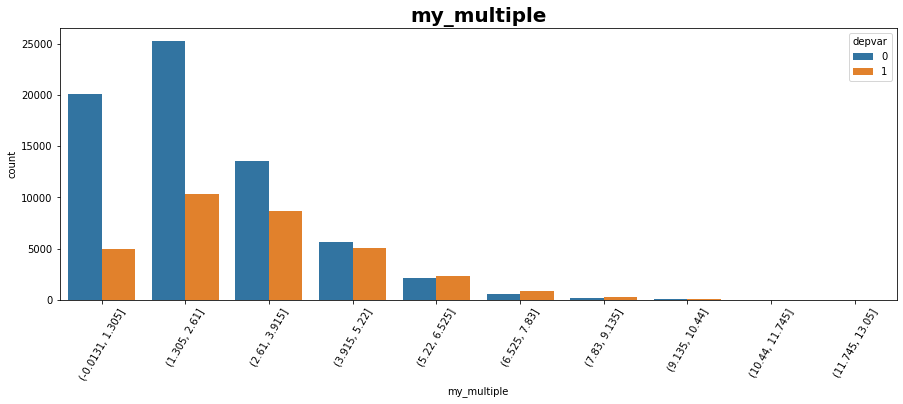

In [90]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple, hue='depvar', data=my_df).set_title("my_multiple",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

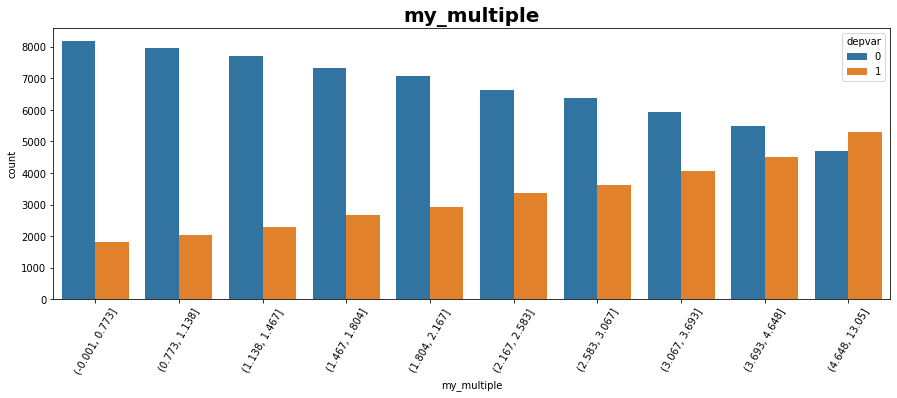

In [142]:
auxmy_multiple = pd.qcut(my_df['my_multiple'], 10)
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple, hue='depvar', data=my_df).set_title("my_multiple",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [92]:
# annual_inc 와 신용등급의 곱
my_df['my_multiple2'] = np.log(my_df['annual_inc']*my_df['fico_range_low'])

In [93]:
auxmy_multiple2 = pd.qcut(my_df['my_multiple2'], 10)

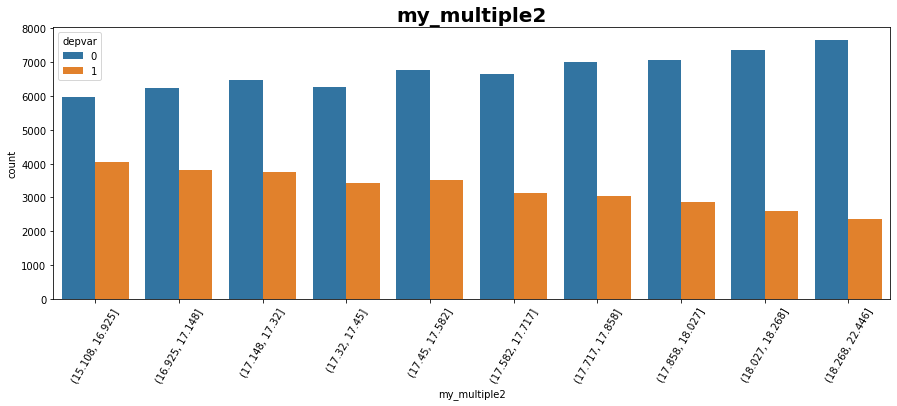

In [94]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple2, hue='depvar', data=my_df).set_title("my_multiple2",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

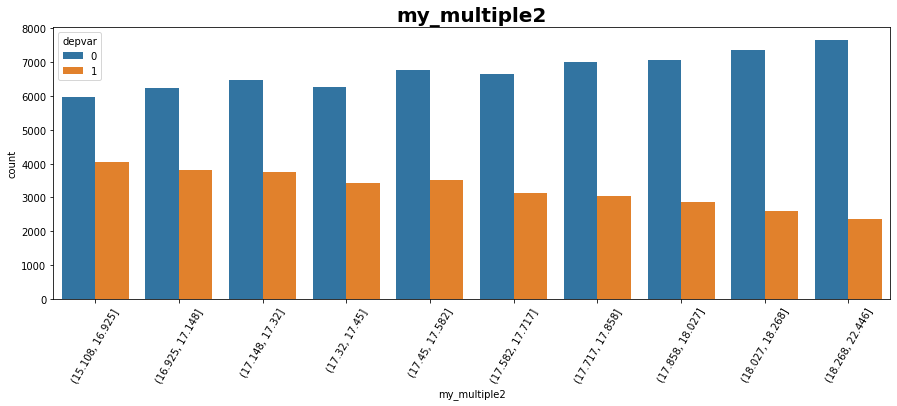

In [95]:
# 로그화 qcut
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple2, hue='depvar', data=my_df).set_title("my_multiple2",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [96]:
#high 비교
my_df['my_multiple3'] = np.log(my_df['annual_inc']*my_df['fico_range_high'])

In [97]:
auxmy_multiple3 = pd.qcut(my_df['my_multiple3'], 10)

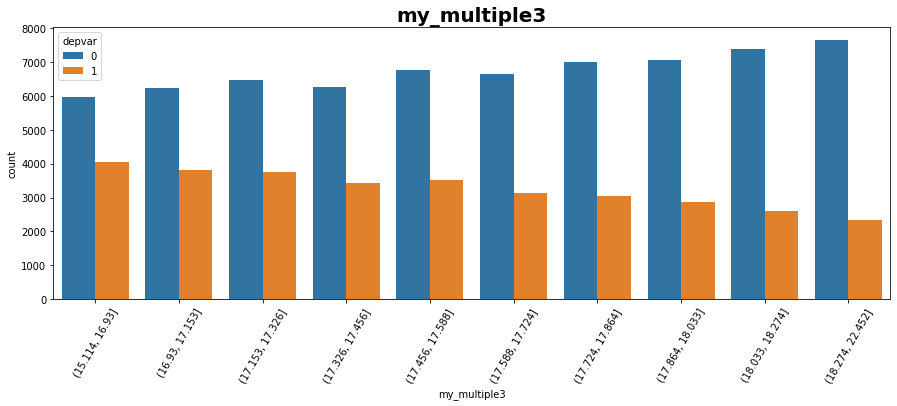

In [98]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple3, hue='depvar', data=my_df).set_title("my_multiple3",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [99]:
# funded_amnt 대출액과 int_rate 이자율 의 곱
my_df['my_multiple4'] = my_df['int_rate']*my_df['funded_amnt']

In [100]:
auxmy_multiple4 = pd.qcut(my_df['my_multiple4'], 10)

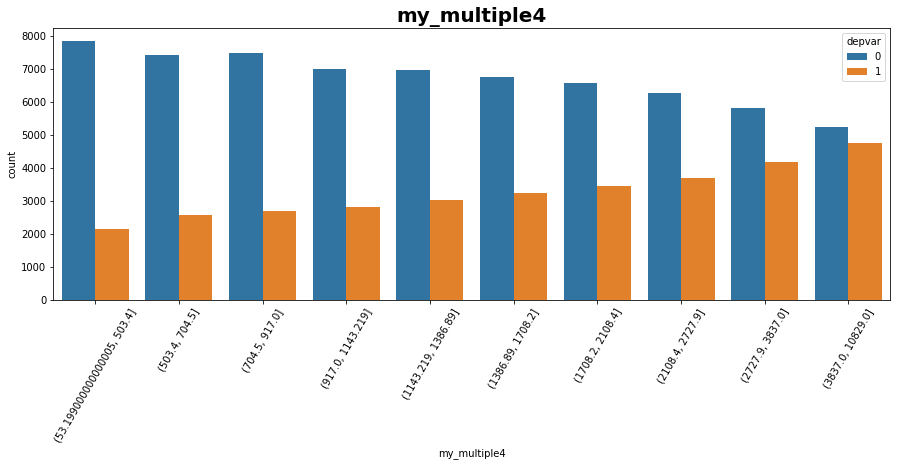

In [101]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple4, hue='depvar', data=my_df).set_title("my_multiple4",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [121]:
#값이 커지면 1이 커지는 방향으로 짠다고 했을떄
# int_rate * dti / log(tot_cul_bal * fico_range_low) 
my_df['my_multiple5'] = my_df['int_rate']*my_df['dti']/np.log(my_df['tot_cur_bal']*my_df['fico_range_low'])

In [122]:
auxmy_multiple5 = pd.qcut(my_df['my_multiple5'], 10)

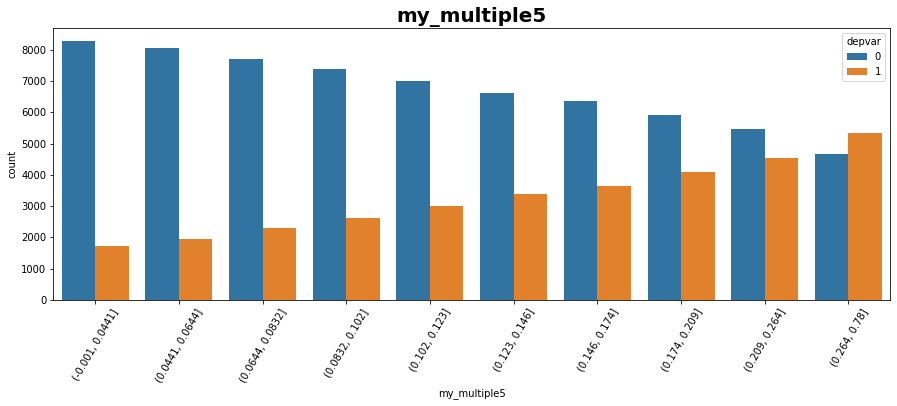

In [123]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple5, hue='depvar', data=my_df).set_title("my_multiple5",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [139]:
## 리볼빙 끼리 revol util / (revol_bal+0.000001)
my_df['my_multiple6'] = my_df['revol_util']/(my_df['revol_bal']+0.0000001)

In [140]:
auxmy_multiple6 = pd.qcut(my_df['my_multiple6'], 10)

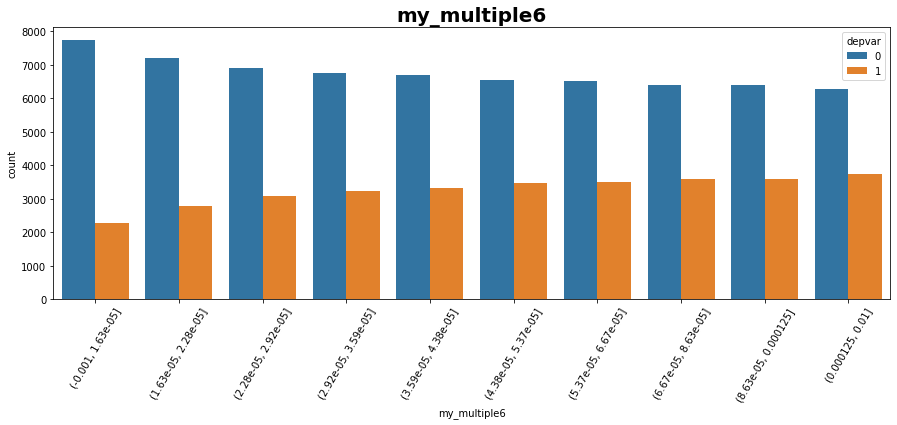

In [141]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple6, hue='depvar', data=my_df).set_title("my_multiple6",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [137]:
my_df[my_df['revol_bal']==0]
my_df.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,...,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,new,my_multiple,my_multiple2,my_multiple3,my_multiple4,my_multiple5,my_multiple6
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,...,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99735.000000
mean,0.130833,7.436061e+04,18.514508,0.343700,0.668880,0.235720,16090.202820,24.675910,0.018810,0.005800,250.588120,1.305281e+05,0.009630,19.288330,0.063820,0.065400,0.326240,0.089410,0.08058,0.059480,0.060710,0.046640,0.045320,0.045690,0.038570,0.075550,0.066410,0.000330,0.466120,0.000070,0.000050,0.110880,0.422550,0.321800,0.390200,0.288000,0.009620,0.226720,0.582810,0.0,...,0.019830,0.01101,0.007310,0.058200,0.000650,0.011250,0.007070,0.000880,0.434430,0.565570,0.489320,0.052360,0.060090,0.045700,0.050750,0.048560,0.051340,0.053430,0.048960,0.050030,0.049460,13735.317750,13729.341073,2.448885e+00,0.855920,11.620700,434.077648,0.537233,0.253327,2491.282802,692.630550,696.630660,0.325690,0.000457,2.487611,17.594911,17.600680,1829.215432,0.141091,0.000065
std,0.044773,7.467409e+04,8.413049,0.905007,0.952044,0.661468,21569.939271,11.883834,0.150321,0.083585,2042.770881,1.503326e+05,0.110079,893.304366,0.468027,0.247232,0.468839,0.285336,0.27219,0.236522,0.238799,0.210868,0.208006,0.208813,0.192569,0.264278,0.248999,0.018163,0.498853,0.008366,0.007071,0.313985,0.493968,0.467169,0.487797,0.452833,0.097609,0.418712,0.493097,0.0,...,0.139417,0.10435,0.085186,0.234122,0.025487,0.105468,0.083786,0.029652,0.495684,0.495684,0.499888,0.222753,0.237655,0.208835,0.219488,0.214947,0.220691,0.224891,0.215786,0.218008,0.216828,8464.825314,8461.694483,1.489496e+01,0.351173,5.458774,265.921746,0.239373,18.053290,2706.262200,29.668017,29.668584,0.468634,0.002878,1.570082,0.548919,0.548875,1444.275609,0.089227,0.000094
min,0.053200,5.360000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.

## 다른 Feature들 생성(7~

In [189]:
my_df['my_multiple7'] = my_df['int_rate']*my_df['funded_amnt']/np.log(my_df['tot_cur_bal']*my_df['fico_range_low']+2)

In [190]:
auxmy_multiple7 = pd.qcut(my_df['my_multiple7'], 10)

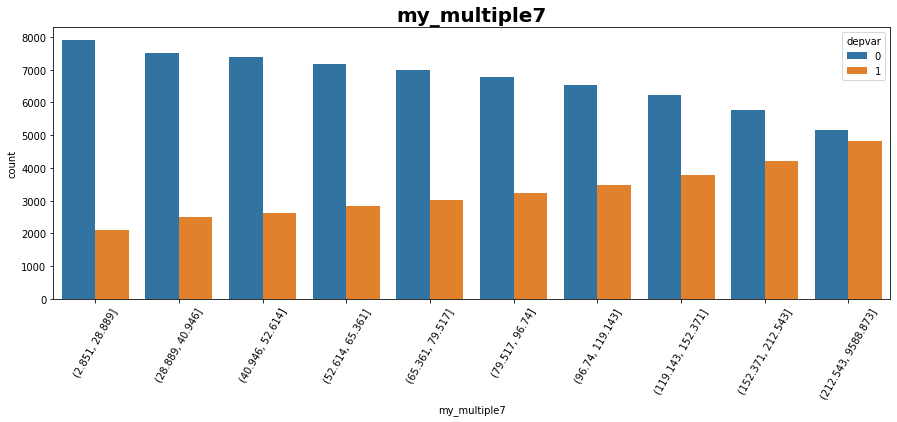

In [191]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple7, hue='depvar', data=my_df).set_title("my_multiple7",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [184]:
# 채무를 이행하지 않은 계좌의수 / 전체 계좌수
my_df['my_multiple8'] = my_df['acc_now_delinq']/(np.log(my_df['open_acc'])+0.000001)

In [186]:
auxmy_multiple8 = pd.cut(my_df['my_multiple8'], 10)

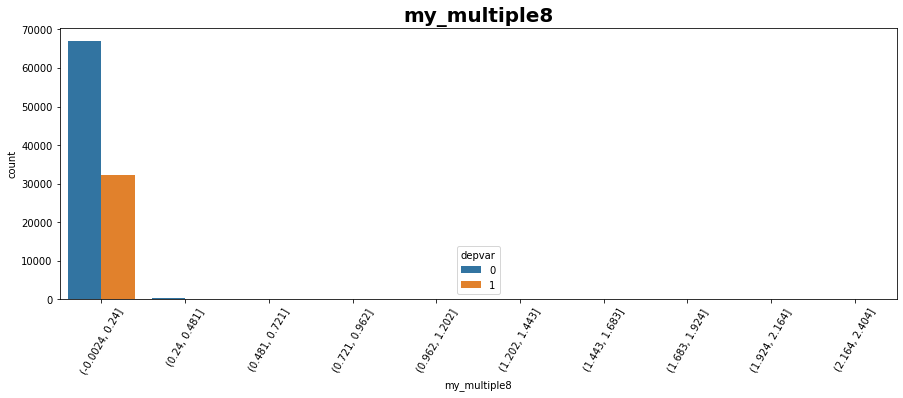

In [188]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple8, hue='depvar', data=my_df).set_title("my_multiple8",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [181]:
auxmy_multiple8 = pd.cut(my_df[my_df['my_multiple8']>0].my_multiple8, 8)

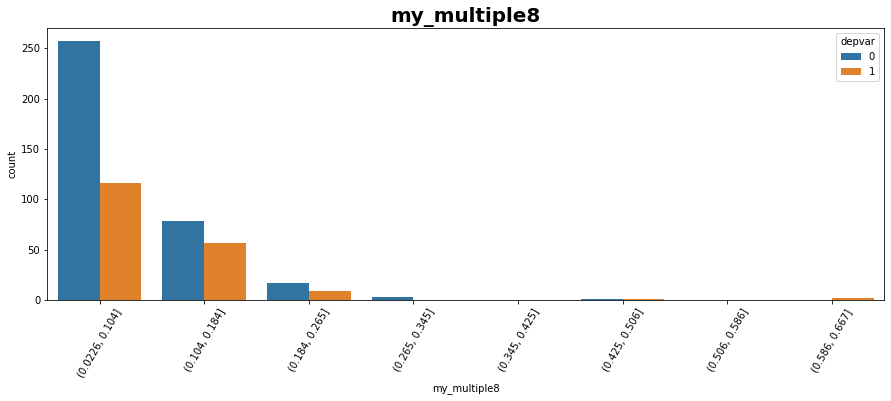

In [182]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple8, hue='depvar', data=my_df[my_df['my_multiple8']>0]).set_title("my_multiple8",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [177]:
type(my_df[my_df['my_multiple8']>0].my_multiple8)

pandas.core.series.Series

In [157]:
my_df[(my_df['acc_now_delinq']!=0)&(my_df['depvar']==1)].shape  #541개중 185개

(185, 84)

In [170]:
# 경향성있는거 다곱해봤는데 1번과 4번의 중간이네
my_df['my_multiple9'] = np.log(my_df['int_rate']*my_df['funded_amnt'])*my_df['dti']

In [171]:
auxmy_multiple9 = pd.qcut(my_df['my_multiple9'], 10)

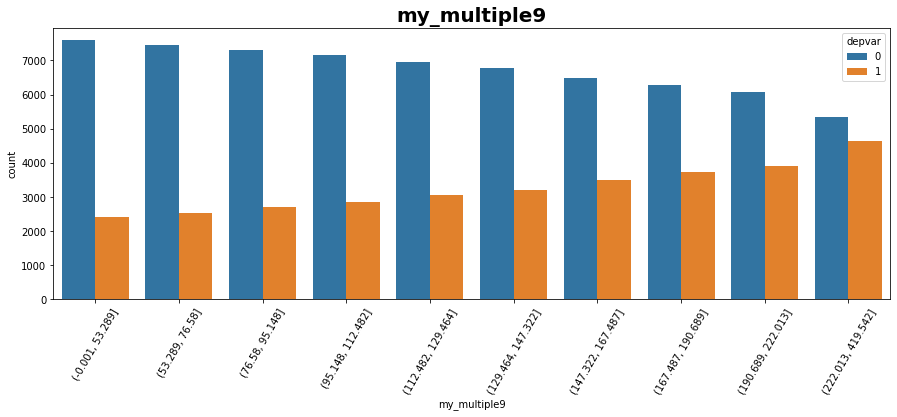

In [172]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple9, hue='depvar', data=my_df).set_title("my_multiple9",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [194]:
# ficolow 와 ficohigh의 곱
my_df['my_multiple10'] = np.log(my_df['fico_range_low']*my_df['fico_range_high']+1)

In [196]:
auxmy_multiple10 = pd.cut(my_df['my_multiple10'], 10)

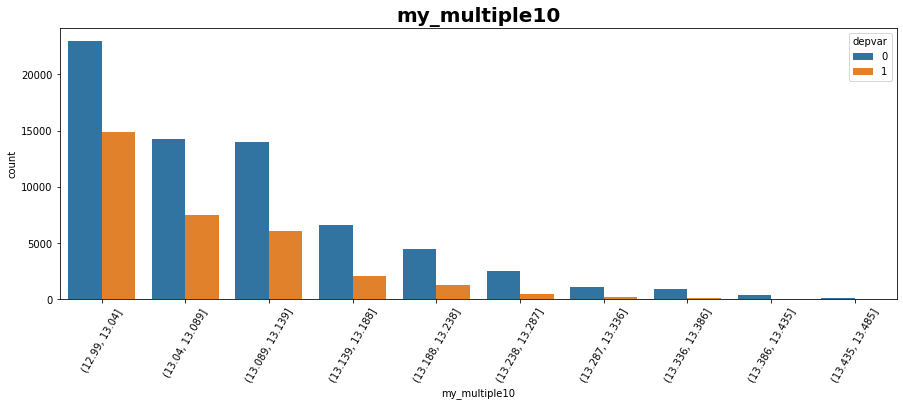

In [197]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple10, hue='depvar', data=my_df).set_title("my_multiple10",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [199]:
my_df['my_multiple11'] = my_df['installment']/ my_df['annual_inc']

In [200]:
auxmy_multiple11 = pd.qcut(my_df['my_multiple11'], 10)

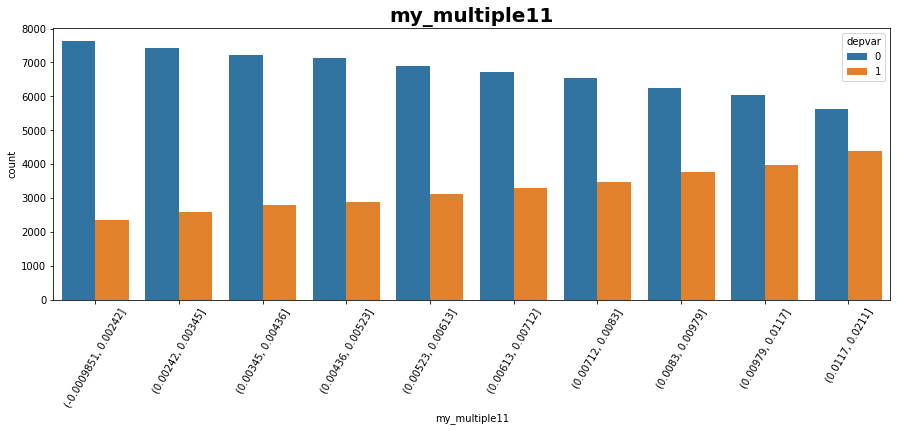

In [201]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxmy_multiple11, hue='depvar', data=my_df).set_title("my_multiple11",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [249]:
baby = my_df.groupby([my_df.term1, my_df.emp_length12, my_df.home_ownership6, my_df.verification_status3, my_df.initial_list_status1])
baby

In [225]:
baby.count()

int_rate  ...  my_multiple12
term1 emp_length12 home_ownership6 verification_status3            ...               
0     0            0               0                         5221  ...           5221
                                   1                         4072  ...           4072
                   1               0                         2754  ...           2754
                                   1                         1852  ...           1852
      1            0               0                           66  ...             66
                                   1                          289  ...            289
                   1               0                           24  ...             24
                                   1                          130  ...            130
1     0            0               0                        33779  ...          33779
                                   1                        10524  ...          10524
                   1               0                        27069  ...          27069
                                   1                         8088  ...           8088
      1            0               0                         1503  ...           1503
                                   1                         2291  ...           2291
                   1               0                          784  ...            784
                                   1                         1554  ...           1554

[16 rows x 84 columns]

In [ ]:
baby.mean()

In [ ]:
baby['depvar'].describe()

In [ ]:
baby['depvar'].sum()

In [252]:
# 새로운것 분류기준 형성
my_df['my_clf1'] = my_df.groupby([my_df.term1, my_df.emp_length12, my_df.home_ownership6, my_df.verification_status3, my_df.initial_list_status1])['depvar'].transform('mean')

In [253]:
my_df['my_clf1'].describe()

count    100000.000000
mean          0.325690
std           0.084384
min           0.227838
25%           0.270696
50%           0.308101
75%           0.370123
max           0.724638
Name: my_clf1, dtype: float64

my_clf2는 전처리 필요함

In [ ]:
my_df

In [257]:
my_df.loc[my_df['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0   # 0번 추심 발생횟수
my_df.loc[my_df['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1   # 1번 이상 추심 발생횟수
my_df['my_clf2'] = my_df.groupby([my_df.term1, my_df.emp_length12, my_df.home_ownership6, my_df.verification_status3, my_df.initial_list_status1, my_df.collections_12_mths_ex_med, my_df.initial_list_status2])['depvar'].transform('mean')

In [258]:
my_df['my_clf2'].describe()

count    100000.000000
mean          0.325690
std           0.085189
min           0.000000
25%           0.269539
50%           0.306611
75%           0.368435
max           0.833333
Name: my_clf2, dtype: float64

In [260]:
my_df.groupby([my_df.term1, my_df.emp_length12, my_df.home_ownership6, my_df.verification_status3, my_df.initial_list_status1, my_df.collections_12_mths_ex_med, my_df.initial_list_status2])['depvar'].mean()

term1  emp_length12  home_ownership6  verification_status3  initial_list_status1  collections_12_mths_ex_med  initial_list_status2
0      0             0                0                     0                     0                           1                       0.425518
                                                                                  1                           1                       0.400000
                                                            1                     0                           0                       0.449221
                                                                                  1                           0                       0.535714
                                      1                     0                     0                           1                       0.425418
                                                                                  1                           1                       0.466667
           

In [261]:
my_df.groupby([my_df.term1, my_df.emp_length12, my_df.home_ownership6, my_df.verification_status3, my_df.initial_list_status1, my_df.collections_12_mths_ex_med, my_df.initial_list_status2])['depvar'].count()

term1  emp_length12  home_ownership6  verification_status3  initial_list_status1  collections_12_mths_ex_med  initial_list_status2
0      0             0                0                     0                     0                           1                        3041
                                                                                  1                           1                          35
                                                            1                     0                           0                        2117
                                                                                  1                           0                          28
                                      1                     0                     0                           1                        1676
                                                                                  1                           1                          15
                             

In [ ]:
####### groupby 같은거 써써 한번 확인해보는 것도 좋을거같은데 ########

## 상한선 설정 및 구간 나누기
#### 단순 트리모델에선 이게 성능이 안좋지만, NN에선 과적합을 제외하곤 의미 있어짐

In [102]:
df2 = df.copy()

In [103]:
# max값 삽입해주기
df2.loc[df2['tot_cur_bal']>1200000, 'tot_cur_bal'] = 1200000
df2.loc[df2['annual_inc']>480000, 'annual_inc'] = 480000
df2.loc[df2['revol_bal']>290000, 'revol_bal'] = 290000
df2.loc[df2['revol_util']>1.785, 'revol_util'] = 1.785
df2.loc[df2['total_rec_late_fee']>53, 'total_rec_late_fee'] = 53
df2.loc[df2['total_acc']>89, 'total_acc'] = 89
df2.loc[df2['open_acc']>41, 'open_acc'] = 41

In [ ]:
# 구간 축약하기 // aux(auxiliary) = 보조의
# 결과를 보면 Feature importance가 그렇게 의미있는 것 같지 않음
# 구간 몰려있는 애들 뒤에 다 짤라서, 바로앞구간 max값으로 치환해주고 또 구간나눠서 보는게 의미있을것같은데
auxtotal_rec_int = pd.cut(df2['total_rec_int'], 6) #구간마다 1:2 구조임. 특징X
auxint_rate = pd.cut(df2['int_rate'], 15)      # 뒤쪽일수록 1비율 큼. 의미O
auxinstallment = pd.cut(df2['installment'], 15)  #특징 X
auxtot_cur_bal = pd.cut(df2['tot_cur_bal'], 10)  #뒤쪽으로 갈수록 1비율 낮음
auxdti = pd.cut(df2['dti'], 10)                # 뒤쪽으로 갈수록 0비율 높음 의미O
auxannual_inc = pd.cut(df2['annual_inc'], 10)  # 처음 1구간에 몰려있음
auxrevol_bal = pd.cut(df2['revol_bal'], 10)    # 처음 2구간에 몰려있음
auxrevol_util = pd.cut(df2['revol_util'], 10)  # 처음 2구간에 몰려있음
# auxtotal_rec_late_fee = pd.cut(df['total_rec_late_fee'], 10)  # 처음 1구간에 몰려있음
auxtotal_acc = pd.cut(df2['total_acc'], 10)    #특징 X
auxopen_acc = pd.cut(df2['open_acc'], 10)      #특징 X
auxfico_range_low = pd.cut(df2['fico_range_low'], 10)  #앞쪽일수록 1비율 큼. 의미O
# auxfunded_amnt_inv = pd.cut(df2['funded_amnt_inv'], 10)  #앞쪽일수록 0이 좀더 큰것같긴한데 미미함
auxfico_range_high = pd.cut(df2['fico_range_high'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfunded_amnt = pd.cut(df2['funded_amnt'], 10)  #앞쪽일 수록 0이 살짝 큰것같은데 미미함.
auxinq_last_6mths = pd.cut(df2['inq_last_6mths'], 7) #뒤로갈수록 1비율 높긴하네
# aux_list = [auxtotal_rec_int, auxint_rate, auxinstallment, 
#             auxtot_cur_bal, auxdti, auxannual_inc, auxrevol_bal, auxrevol_util,
#             auxtotal_acc, auxopen_acc, auxfico_range_low,
#             auxfunded_amnt_inv, auxfico_range_high, auxfunded_amnt]

In [ ]:
# qcut
# auxtotal_rec_int = pd.qcut(df['total_rec_int'], 6) #구간마다 1:2 구조임. 특징X
# auxint_rate = pd.qcut(df['int_rate'], 15)      # 뒤쪽일수록 1비율 큼. 의미O
# auxinstallment = pd.qcut(df['installment'], 15)  #특징 X
# auxtot_cur_bal = pd.qcut(df['tot_cur_bal'], 10)  #처음 2구간에 몰려있음 특징 X
# auxdti = pd.qcut(df['dti'], 10)                # 뒤쪽일수록 1비율 큼. 의미O
# auxannual_inc = pd.qcut(df['annual_inc'], 10)  # 처음 1구간에 몰려있음
# auxrevol_bal = pd.qcut(df['revol_bal'], 10)    # 처음 2구간에 몰려있음
# auxrevol_util = pd.qcut(df['revol_util'], 10)  # 처음 2구간에 몰려있음
# auxtotal_rec_late_fee = pd.cut(df['total_rec_late_fee'], 10)  # 처음 1구간에 몰려있음
# auxtotal_acc = pd.qcut(df['total_acc'], 10)    #특징 X
# auxopen_acc = pd.qcut(df['open_acc'], 10)      #특징 X
# auxfico_range_low = pd.cut(df['fico_range_low'], 10)  #앞쪽일수록 1비율 큼. 의미O
# auxfunded_amnt_inv = pd.qcut(df['funded_amnt_inv'], 10)  #앞쪽일수록 0이 좀더 큰것같긴한데 미미함
# auxfico_range_high = pd.cut(df['fico_range_high'], 10)  #앞쪽일수록 1비율 큼. 의미O
# auxfunded_amnt = pd.qcut(df['funded_amnt'], 10)  #앞쪽일 수록 0이 살짝 큰것같은데 미미함.
# auxinq_last_6mths = pd.cut(df['inq_last_6mths'], 7) #뒤로갈수록 1비율 높긴하네

## 시각화 한것 바탕으로 data 재가공

In [ ]:
## total_rec_fee 먼저 라벨링 6개정도
df2.loc[ df2['total_rec_late_fee'] <= 0.000001, 'total_rec_late_fee'] = 0
df2.loc[(df2['total_rec_late_fee'] > 0.000001) & (df2['total_rec_late_fee'] <= 0.002), 'total_rec_late_fee'] = 1
df2.loc[(df2['total_rec_late_fee'] > 0.002) & (df2['total_rec_late_fee'] <= 0.06), 'total_rec_late_fee'] = 2
df2.loc[(df2['total_rec_late_fee'] > 0.06) & (df2['total_rec_late_fee'] <= 1.7), 'total_rec_late_fee'] = 3
df2.loc[(df2['total_rec_late_fee'] > 1.7) & (df2['total_rec_late_fee'] <= 12), 'total_rec_late_fee'] = 4
df2.loc[df2['total_rec_late_fee']  > 12, 'total_rec_late_fee'] = 5

In [ ]:
df2

,total_rec_int,int_rate,installment,tot_cur_bal,dti,annual_inc,revol_bal,revol_util,total_rec_late_fee,total_acc,open_acc,fico_range_low,funded_amnt_inv,fico_range_high,funded_amnt,inq_last_6mths,depvar
0,157.94,0.0824,37.74,11773,29.19,21000.0,3016,0.076,0.0,26,18,765,1200.0,769,1200,1,0
1,1702.42,0.1299,269.52,21875,4.82,80000.0,5722,0.447,0.0,24,8,665,8000.0,669,8000,1,0
2,1066.64,0.1299,168.45,31868,23.66,38000.0,6511,0.880,0.0,18,7,670,5000.0,674,5000,3,0
3,1256.24,0.1367,510.27,326049,16.27,100000.0,6849,0.457,0.0,30,12,680,15000.0,684,15000,2,1
4,871.04,0.1269,335.45,8840,25.28,30000.0,8197,0.416,0.0,12,8,660,10000.0,664,10000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5373.29,0.1757,718.75,26570,17.67,65000.0,11255,0.780,0.0,21,13,660,20000.0,664,20000,3,1
99996,835.66,0.0890,190.52,6138,2.88,65000.0,2105,0.120,0.0,12,7,765,6000.0,769,6000,0,0
99997,1261.67,0.1349,217.16,96531,32.12,46000.0,8998,0.643,0.0,20,19,665,6400.0,669,6400,1,0
99998,1357.69,0.2115,207.64,3875,4.53,31000.0,3875,0.731,0.0,4,3,710,5500.0,714,5500,1,1


In [ ]:
df3 = df2.copy()

In [ ]:
# col list_for_d3 만들어줌 , 그리고 df3에 라벨링하지 않을 컬럼을 리스트에서 'total_rec_late_fee' 'inq_last_6mths'  'depvar' 제거
col_list_for_df3 = list(df3.columns)
col_list_for_df3.remove("total_rec_late_fee")
col_list_for_df3.remove('inq_last_6mths')
col_list_for_df3.remove("depvar")

# aux_list는 위의 3가지 빠져있음
aux_dict = {'total_rec_int':auxtotal_rec_int, 'int_rate':auxint_rate, 'installment':auxinstallment, 
            'tot_cur_bal':auxtot_cur_bal, 'dti':auxdti, 'annual_inc':auxannual_inc, 'revol_bal':auxrevol_bal, 'revol_util':auxrevol_util,
            'total_acc':auxtotal_acc, 'open_acc': auxopen_acc, 'fico_range_low':auxfico_range_low,
            'funded_amnt_inv':auxfunded_amnt_inv, 'fico_range_high':auxfico_range_high, 'funded_amnt':auxfunded_amnt}

In [ ]:
# name이 string타입이라 그냥 넣어주면 됨
for name in col_list_for_df3:
    df3[name] = LabelEncoder().fit_transform(aux_dict[name])
df3

,total_rec_int,int_rate,installment,tot_cur_bal,dti,annual_inc,revol_bal,revol_util,total_rec_late_fee,total_acc,open_acc,fico_range_low,funded_amnt_inv,fico_range_high,funded_amnt,inq_last_6mths,depvar
0,0,1,0,0,5,0,0,0,0.0,1,2,5,0,5,0,1,0
1,0,4,2,0,0,0,0,0,0.0,1,0,0,1,0,1,1,0
2,0,4,1,0,4,0,0,0,0.0,0,0,0,1,0,1,3,0
3,0,4,4,1,3,0,0,0,0.0,1,1,1,3,1,3,2,1
4,0,4,2,0,5,0,0,0,0.0,0,0,0,2,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,7,6,0,3,0,0,0,0.0,1,1,0,4,0,4,3,1
99996,0,2,1,0,0,0,0,0,0.0,0,0,5,1,5,1,0,0
99997,0,4,1,0,6,0,0,0,0.0,1,2,0,1,0,1,1,0
99998,0,9,1,0,0,0,0,0,0.0,0,0,2,1,2,1,1,1


In [ ]:
# 위에서 시각화했던 값 crosstab으로 수치 실제로 확인
# col_list = 위에서 feature top16개뽑은것 + 결과값(depvar)
for col in col_list[:-1]:
    print(pd.crosstab(df3[col], df3['depvar']))

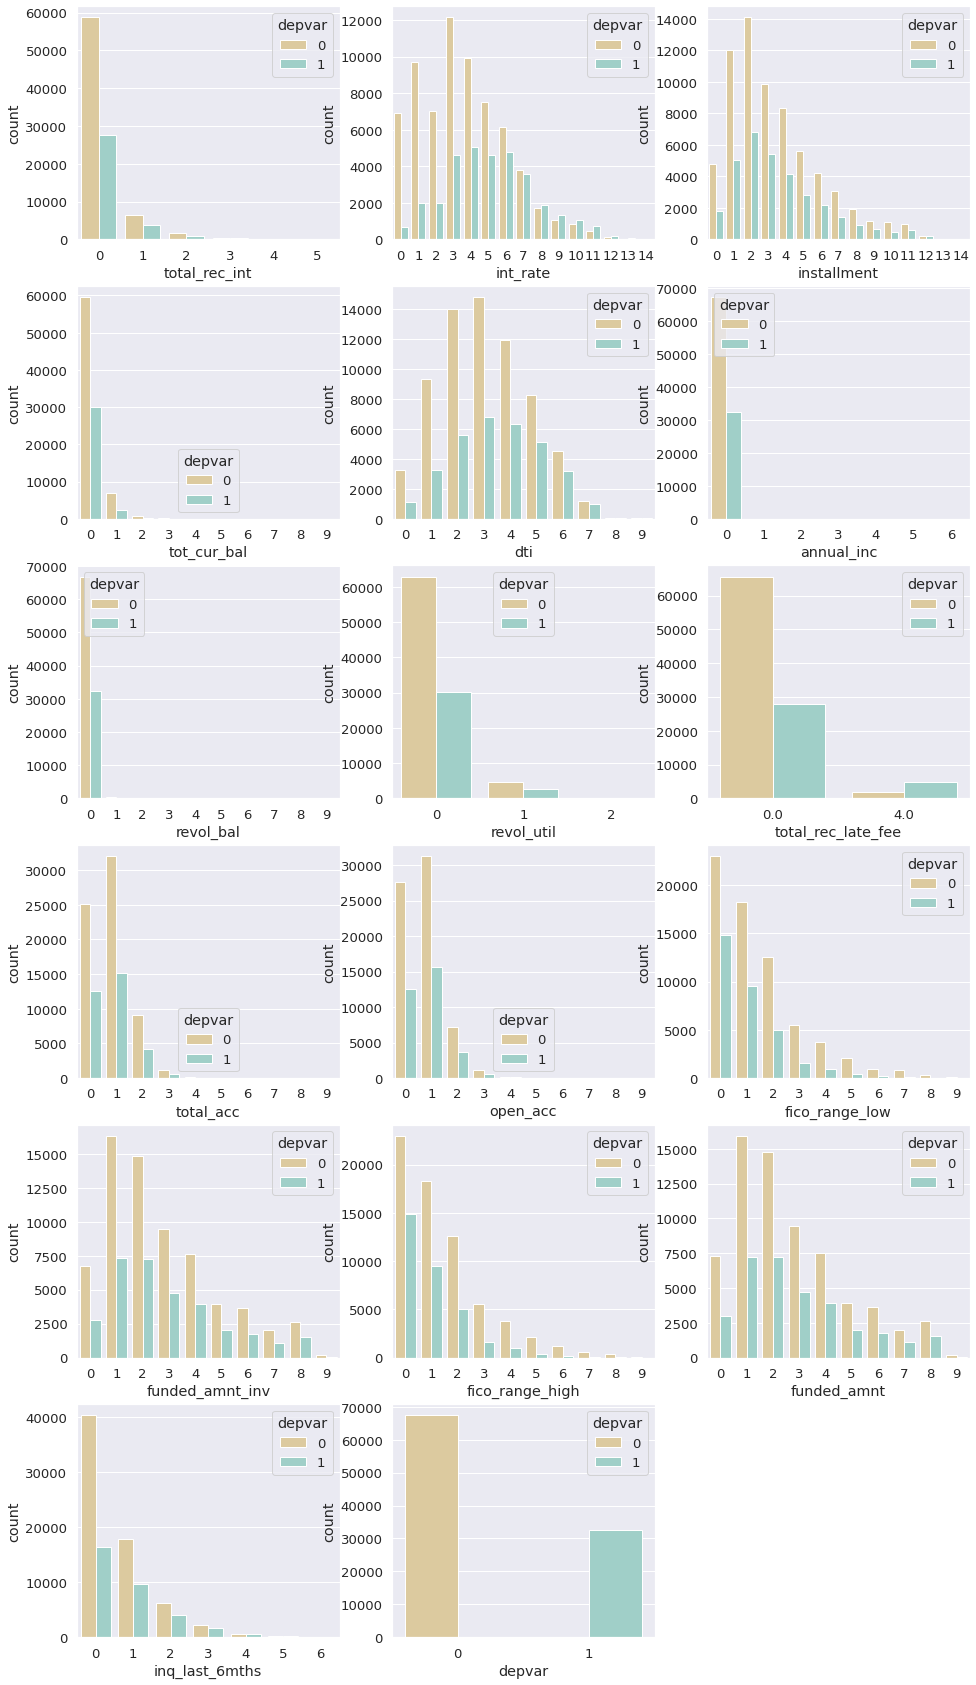

In [ ]:
plt.figure(figsize=(16, 30))
sns.set(font_scale=1.2)
sns.set_style('darkgrid') #'whitegrid', 'ticks', 'white', 'dark'

# 전체 17개 feature에 대해서 그래프 그림
for i, feature in enumerate(col_list):
    plt.subplot(6, 3, i+1)
    sns.countplot(data=df3, x=feature, hue='depvar', palette='BrBG')

In [ ]:
# 원핫인코딩으로 바꿔줌
df4 = pd.get_dummies(df3, columns=col_list[:-1])
df4.columns

Index(['depvar', 'total_rec_int_0', 'total_rec_int_1', 'total_rec_int_2',
       'total_rec_int_3', 'total_rec_int_4', 'total_rec_int_5', 'int_rate_0',
       'int_rate_1', 'int_rate_2',
       ...
       'funded_amnt_7', 'funded_amnt_8', 'funded_amnt_9', 'inq_last_6mths_0',
       'inq_last_6mths_1', 'inq_last_6mths_2', 'inq_last_6mths_3',
       'inq_last_6mths_4', 'inq_last_6mths_5', 'inq_last_6mths_6'],
      dtype='object', length=147)

In [ ]:
# Train, Valid split
X = df4.drop('depvar', axis=1)
y = df4['depvar']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## Resid Feature 시각화

In [ ]:
# 상위 Top Feature 추출하고, 나머지 columns도 분석
_, col_list_top = ext_top_feat(df, fi, 16)

col_resid_list =list(df.columns)
for i, name in enumerate(col_list_top):
    col_resid_list.remove(name)
col_resid_list.append('depvar')

In [ ]:
#df = 모든 정보가 담긴 DataFrame
#df2_resid = 중요도있는 Feature 제외한 나머지 Feature들로 이루어진 DaraFrame
df2_resid = df[col_resid_list]

In [ ]:
df2_resid.nunique()
# nunique갯수 많은 tot_coll_amt , delinq_amnt 2개만 cut으로 구간 나눠줄예정

In [ ]:
# 시각화 한것 보고 특정값 이상 max로 치환하고 다시 구간 나누기
df2_resid.loc[df2_resid['tot_coll_amt']>0.00008, 'tot_coll_amt'] = 0.00008
df2_resid.loc[df2_resid['delinq_amnt']>0.001, 'delinq_amnt'] = 0.001

In [ ]:
# 구간 나눠주기
auxtot_coll_amt = pd.cut(df2_resid['tot_coll_amt'], 10)
auxdelinq_amnt = pd.cut(df2_resid['delinq_amnt'], 10)

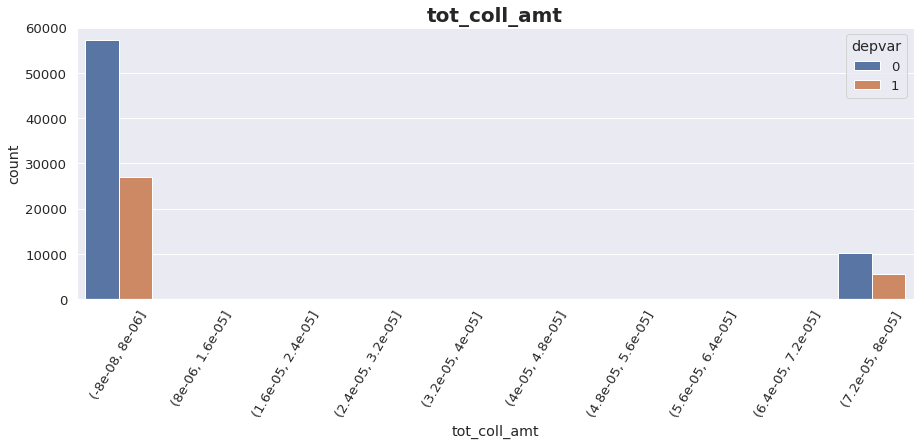

In [ ]:
# 0과 나머지로 구분예정
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtot_coll_amt, hue='depvar', data=df2_resid).set_title("tot_coll_amt",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [ ]:
# 의미없는 컬럼, 분석시 제외예정
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxdelinq_amnt, hue='depvar', data=df2_resid).set_title("delinq_amnt",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [ ]:
# tot_coll_amt 3구간으로 나눠줌
df2_resid.loc[df2_resid['tot_coll_amt'] <= 0.00001, 'tot_coll_amt'] = 0
df2_resid.loc[(df2_resid['tot_coll_amt'] > 0.00001) & (df2_resid['tot_coll_amt'] <= 0.02), 'tot_coll_amt'] = 1
df2_resid.loc[df2_resid['tot_coll_amt']  > 0.02, 'tot_coll_amt'] = 2

df2_resid.loc[df2_resid['delinq_2yrs'] <= 4, 'delinq_2yrs'] = 0                                     #4년이하 2:1 비율
df2_resid.loc[(df2_resid['delinq_2yrs'] > 4) & (df2_resid['delinq_2yrs'] <= 10), 'delinq_2yrs'] = 1 #5~8년 채무불이행비율 증가
df2_resid.loc[df2_resid['delinq_2yrs']  > 10, 'delinq_2yrs'] = 2                                    #9년 이상

df2_resid.loc[df2_resid['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0     # 0번 추심 발생횟수
df2_resid.loc[df2_resid['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1     # 1번 이상

df2_resid.loc[df2_resid['tax_liens'] <= 0.1, 'tax_liens'] = 0                                   #0번 세금 저당권 2:1 비율
df2_resid.loc[(df2_resid['tax_liens'] > 0.1) & (df2_resid['tax_liens'] <= 1.5), 'tax_liens'] = 1 #1번 채무불이행비율 증가
df2_resid.loc[df2_resid['tax_liens']  > 1.5, 'tax_liens'] = 2 

In [ ]:
#df2에서 Label처리 한것
df3_resid = df2_resid.copy()

In [ ]:
# resid는 대부분 원핫벡터나 어느정도 숫자가 몇개안되는 애들임
# tot_coll_amt는 값처리해줬고, delinq_amnt는 의미없는 벡터라 삭제
# 밑에 크로스탭 결과로 'out_prncp', 'out_prncp_inv' 추가 삭제
df3_resid = df3_resid.drop(columns=['delinq_amnt', 'out_prncp', 'out_prncp_inv', 'acc_now_delinq'])

In [ ]:
df3_resid

,delinq_2yrs,pub_rec,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,chargeoff_within_12_mths,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,term1,depvar
0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
4,0,2,0,0,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1,1,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1
99996,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
99997,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
99998,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1


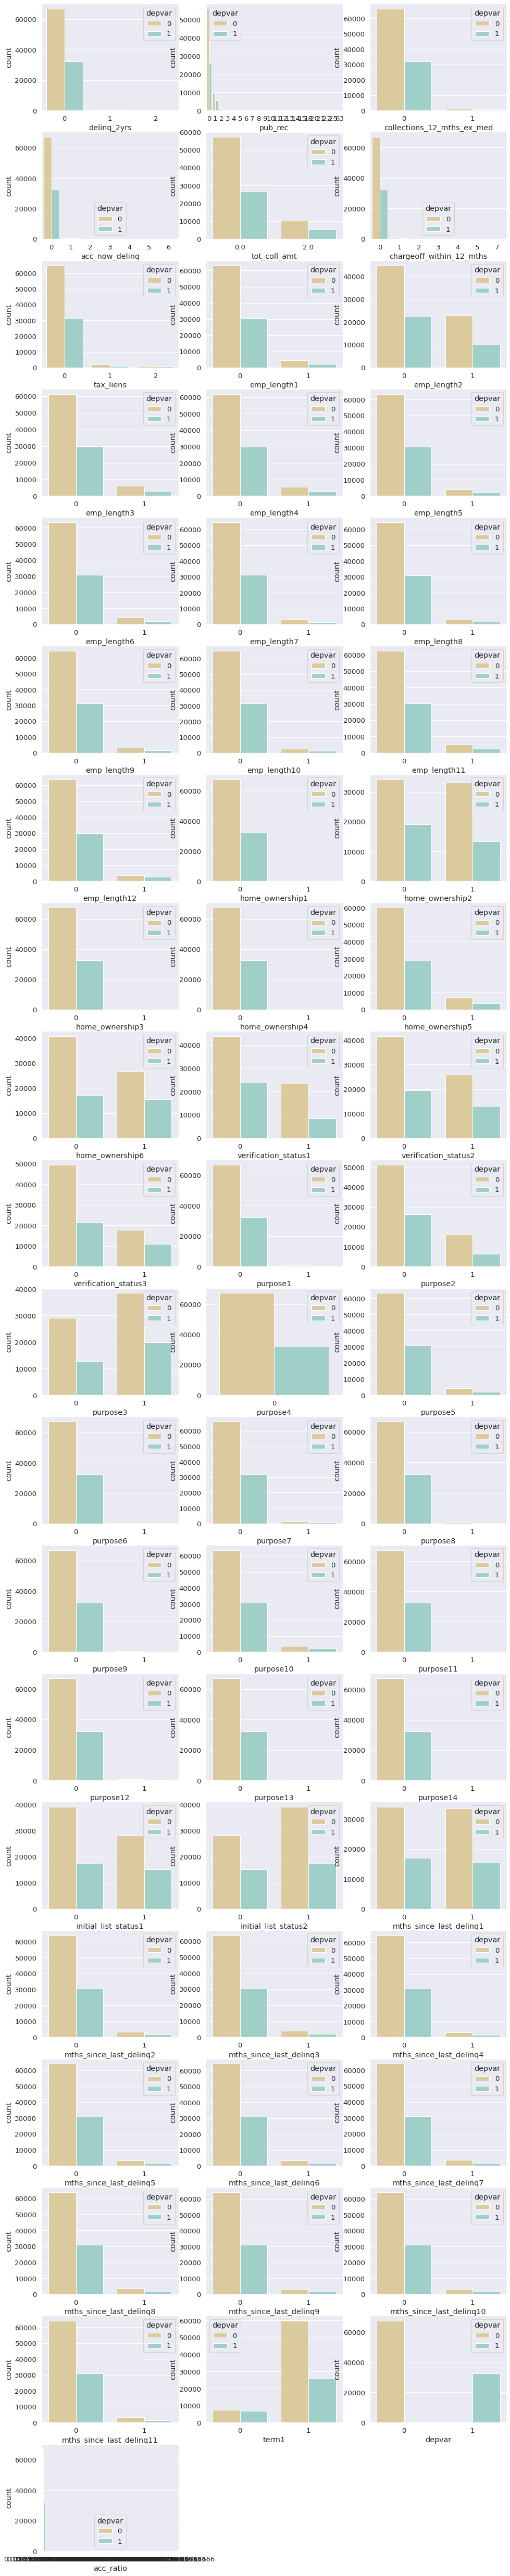

In [ ]:
# col_resid_list2 는 아까 삭제한 칼럼 뺴준 것
col_resid_list2 = list(df3_resid.columns)

plt.figure(figsize=(16, 90))
sns.set(font_scale=1.2)
sns.set_style('darkgrid') #'whitegrid', 'ticks', 'white', 'dark'

# col_resid_list = 56개 feature + 1개 결과값
for i, feature in enumerate(col_resid_list2):
    plt.subplot(20, 3, i+1)
    sns.countplot(data=df3_resid, x=feature, hue='depvar', palette='BrBG')

In [ ]:
# 위에서 시각화했던 값 수치 실제로 확인 크로스탭
for col in col_resid_list2[:]:
    print(pd.crosstab(df3_resid[col], df3_resid['depvar']))


depvar           0      1
delinq_2yrs              
0            66948  32256
1              453    292
2               30     21
depvar       0      1
pub_rec              
0        55997  26002
1         9332   5390
2         1373    770
3          417    229
4          159     91
5           79     40
6           31     24
7           14      9
8            9      4
9            3      0
10           7      3
11           2      1
12           1      1
13           1      1
14           2      1
15           0      1
18           1      0
20           1      0
21           0      1
22           1      0
25           0      1
63           1      0
depvar                          0      1
collections_12_mths_ex_med              
0                           66366  31924
1                            1065    645
depvar              0      1
acc_now_delinq              
0               67075  32384
1                 338    176
2                  15      6
3                   2      1
4   